In [1]:
__author__ = "me"
__date__ = "2015_10_13"
%pylab inline
import pandas as pd
# import numpy as np
# import geopandas as gp
# import datetime
import math
import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)
from palettable.colorbrewer.qualitative import Paired_11

CUSP = os.getenv('CUSP_DIR')

Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def getAllFinished(mypath):
    cols = ['ID',
            'category',
            'checkIns',
            'createdAt',
            'description',
            'genCategory',
            'lat','lon',
            'name',
            'photoCount',
            'price',
            'query','rating',
            'tags','tileID',
            'time','tips',
            'users','verified']
    
    files = [ f for f in os.listdir(mypath) if (os.path.isfile(os.path.join(mypath,f)) and ('.csv' in f)) ]
#     print files
    return {k.replace('.csv',''):pd.read_csv(os.path.join(mypath,k))[cols] for k in files}

In [3]:
dfs = getAllFinished(CUSP +'/project/Square_cities/data/finished_data/')

/Users/casy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: DtypeWarning: Columns (1,3,4,5,7,8,10,11,13,14,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
def convertDT(df):
    df['createdAt'] = pd.to_datetime(df['createdAt'], yearfirst=1,errors='coerce')
    return df

In [5]:
for k in dfs:
    dfs[k] =convertDT(dfs[k])

In [7]:
def annotate_plot(frame, label_col, plot_col1,plot_col2,  **kwargs):
    for label, x, y in zip(frame[label_col], frame[plot_col1], frame[plot_col2]):
        plt.annotate(label.decode('utf8'), xy=(x+10, y+10), **kwargs)

In [9]:


# def aggData(df):
#     cats = df.groupby('category').agg({'genCategory':lambda x: x.iloc[0],"checkIns":sum,'tips':sum, 'users':sum,'photoCount':sum})
#     return cats.reset_index()

# def scatterCat(city):
#     df = dfs[city] 
#     cats = aggData(df).groupby('genCategory')
    
#     fig, ax = plt.subplots(figsize=(21,12))
    
#     for i, (name, g) in enumerate(cats):
#         ax.plot(g.checkIns,g.users, marker='o',   color=Paired_11.mpl_colors[i], linestyle='', alpha =.4,ms=10, label=name)
#         annotate_plot(g[g.checkIns > 2000000], 'category', 'checkIns', 'users', fontsize=14)
#     ax.legend(numpoints=1, loc='best');    

#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(7) 

#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(7) 
#     ax.xaxis.get_major_ticks()[-1].set_visible(False)
#     ax.set_yticklabels( [int(x) for x in ax.get_yticks()], rotation=90)


In [10]:
# scatterCat('Kiev')


In [11]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10


def plotTS(df, ax, name, color):
    x = df[['createdAt','ID']].set_index('createdAt').resample('1W', how='count').rename(columns={'ID':name})
    x.plot(kind='Area',color=color, legend=0, alpha=.3, ax=ax,grid=0) # 'CornflowerBlue'
    ax.set_xlabel('Venues created, per week', x=0.93)
    ax.set_yticks((0,roundup(x.max().ix[0])))
    ax.yaxis.get_major_ticks()[0].set_visible(False)
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(7) 

In [12]:
            
def plotHorisont(df, ax1, name, color, nfolds=3):
    ts = df[['createdAt','ID']].set_index('createdAt').resample('1W', how='count')
    axes = [ax1]

    x = ts.index
    y = ts.ID
    
    for n in range(1, nfolds):
        newax = axes[-1].twinx()
        axes.append(newax)

    ylims = np.linspace(y.min(), y.max(), nfolds + 1)
    for n, ax in enumerate(axes):        
        ax.fill_between(x, y, y2=ylims[n], facecolor=color, alpha=1.0/nfolds, zorder=n)
        ax.set_ylim([ylims[n], ylims[n+1]])
        ax.set_yticklabels([])
        ax.set_yticks([])
        
    step = y.max()/nfolds
    ax1.set_yticks([step*(nfolds-1),step*(nfolds)])
    ax1.set_yticklabels((0,step),fontsize=7)
    ax1.yaxis.get_major_ticks()[0].set_visible(False)
#     ax1.grid(b=False)
     

/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


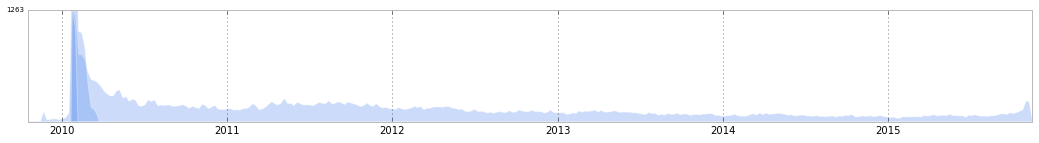

In [13]:
fig, ax = plt.subplots(figsize=(18,2))
plotHorisont(dfs['Tokyo'],ax,'Tokyo','CornflowerBlue')

In [14]:
def plotCategoriesTS(city):
    df = dfs[city]
    cats = df.groupby('genCategory')

    fig, axes = plt.subplots(len(cats), sharex=True, figsize=(21,8))

    
    for i, (name, g) in enumerate(cats):
        plotHorisont(g,axes[i],name, color=Paired_11.mpl_colors[i])
        axes[i].set_title(name, fontsize=9, horizontalalignment='left', x= 0.005, y=0.47)

    
    plt.suptitle(city, fontsize=34, fontweight='bold', horizontalalignment='left',x=0.125,y=0.08)
    plt.text(1,-1.25,'Venues created, per week, 3-fold\nPlease, read readme file', fontsize=11,  ha='right', transform=axes[-1].transAxes)   

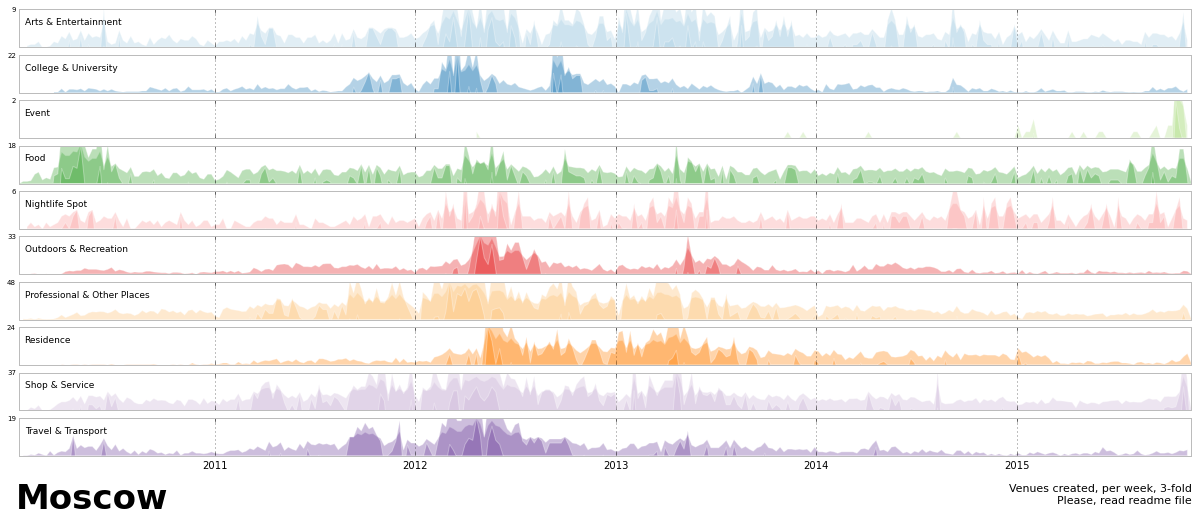

In [15]:
plotCategoriesTS('Moscow')

PUI = os.getenv('PUI2015')
plt.savefig(PUI +'/HW8/horisont_Moscow.png', bbox_inches='tight')